## Pendulum Dynamics
We will explore the use of a Kalman Filter to estimate the state of a free pendulum starting from an initial state with damped isolation. We will first explore the use of a linear Kalman Filter based on a linearized model of the pendulum dynamics. Then, we will look at using an Extended Kalman Filter to estimate the states.
The following are the dynamics of the system:
$$\dot{x} =\left\lbrack \begin{array}{c}
\dot{\theta} \\
\ddot{\theta} 
\end{array}\right\rbrack =\left\lbrack \begin{array}{c}
\dot{\theta} \\
\frac{-b}{\mathit{\text{mL}}}\dot{\theta} -\frac{g}{L}\sin \left(\theta \right)
\end{array}\right\rbrack$$
Let's integrate this over a fixed time interval with an initial state. 


In [1]:
# Import Required Packages
%matplotlib inline
import sys
from numpy import * # Numpy Lumpy
import matplotlib.pyplot as plt # Plotting 
from control.matlab import * # MATLAB-like functions
from scipy.integrate import odeint
import scipy.linalg
# Utilities
def rmse2(x):
    return sqrt(pow(x[0,:],2).mean()), sqrt(pow(x[1,:],2).mean())
# Some defaults

plt.style.use('ggplot'); plt.rcParams.update({'font.size': 14}); 
# plt.rcParams["figure.figsize"] = [14, 5];

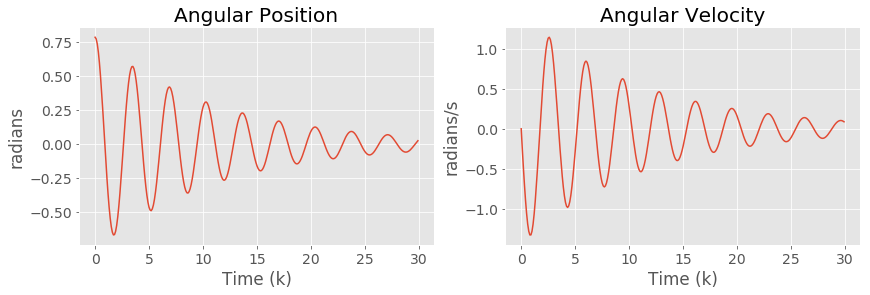

In [2]:
# Pendulum Parameters
m = 0.5;  # Mass of the pendulum
b = 0.25; # Damping Coefficient
L = 2.8;  # Length of the Pendulum 
g = 9.81; # Gravitational Constant, the average nominal value on Earth,
          # not necessarily where you are standing right now. In fact, the gravitational constant varies 0.7% 
          # across different earth locations, but let's get back to our lesson. 

# Pendulum Dynamics
def f(x, t):
#     global m, b, L, g
    return [x[1], -b/(m*L)*x[1]-g/L*sin(x[0])]

# Initial Condition
x0 = [pi/4, 0]

# Solve for the pendulum trajectory using an ODE solver
Ts = 0.01; Tstart = 0; Tfinal = 30; # # Start & End Time
ts = arange(Tstart, Tfinal, Ts)
x = array(odeint(f, x0, ts)); x = x.transpose()
# Integrate again, but interpolate at differetn time steps
Tm = 0.1; tm = arange(Tstart, Tfinal, Tm);
xm = array(odeint(f, x0, tm)); xm = xm.transpose()
# Let's observe the time response of our system
# Set style and figure properties
fig_ = plt.figure(figsize=(14, 4))
plt.subplot(1,2,1);
plt.plot(tm, xm[0,:]); plt.xlabel("Time (k)"); plt.ylabel("radians"); plt.title('Angular Position');
plt.subplot(1,2,2);
plt.plot(tm, xm[1,:]); plt.xlabel("Time (k)"); plt.ylabel("radians/s"); plt.title('Angular Velocity');

Now let us assume we want to measure the angular position and angular velocity, but we don't have a sophisticated measurement device and so the measurements are noisy. Let's assume the measurement noise is white, Gaussian, not correlated and with zero-mean. Let's add that affect onto the process. Assume the measurements are taken at a sample time of *Tm*

The root-mean-square of the measurement errors for position and velocity are:  (0.25602119392678768, 0.512640711900748)


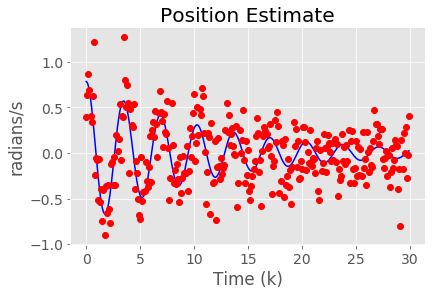

In [3]:
# Noise Properties
theta_std = 0.25; thetadot_std = 0.5;
diagtest = diag([1,2])
x_noise = dot(diag([theta_std, thetadot_std]), random.randn(2,len(tm)));
y = xm + x_noise;
measurement_error = (xm - y);
x_measurement_error_rms = rmse2(measurement_error);
print('The root-mean-square of the measurement errors for position and velocity are: ', x_measurement_error_rms)
fig_ = plt.figure(figsize=(14, 4))
plt.subplot(1,2,1);
plt.plot(tm, xm[0,:],'b'); plt.xlabel("Time (k)"); plt.ylabel("radians"); plt.title('Angular Position');
# plt.subplot(1,2,2);
plt.plot(tm, y[0,:], 'ro'); plt.xlabel("Time (k)"); plt.ylabel("radians/s"); plt.title('Position Estimate');

In [6]:
%run animated_pendulum.py

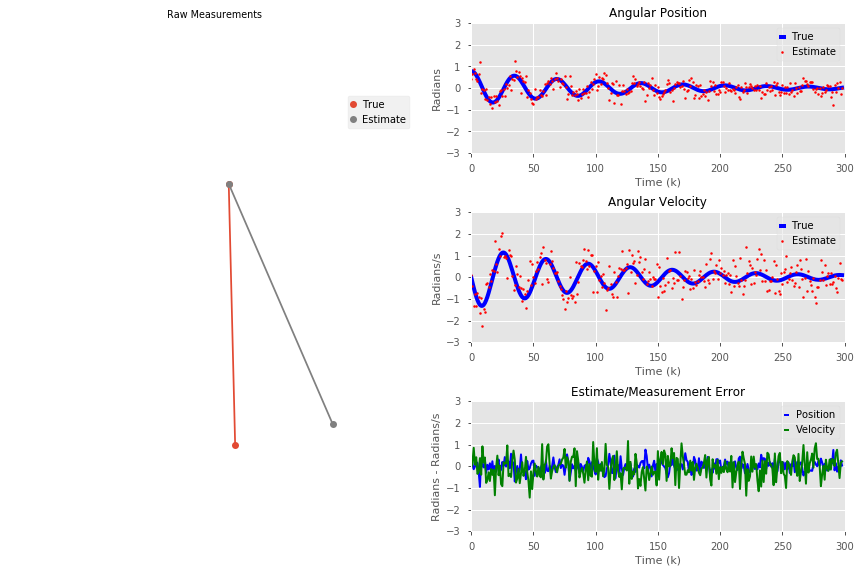

In [18]:
fig = plt.figure(figsize=(12, 8));
annpen = animated_pendulum(fig, tm, Tm, L, xm, y, 'Raw Measurements')
annpen_animation = annpen.get_animation_video(); annpen_animation

Now this may be an exaggeratted noise, we can change the standard deviation of the measurement noise to make it better or worst, but let's keep it and see how well a Kalman Filter can perform.

## Linear Kalman Filter
We clearly don't have a decent measurement system, let's try to apply a Kalman Filter to better estimate our states. Here is a summary of the Kalman Filter for a Discrete Time-Variant Linear System.

Given the dynamic system:
$$x_k =F_{k-1} x_{k-1} +G_{k-1} u_{k-1} +w_{k-1}$$
$$y_k =H_k x_k +v_k$$
$$w_k \sim N\left(0,R\right)$$
$$v_k \sim{N(0, Q)}$$

Initialized as follows:
$${\hat{x} }_0^+ =E\left(x_0 \right)$$
$$P_0^+ =E\left\lbrack \left(x_0 -{\hat{x} }_0^+ \right){\left(x_0 -{\hat{x} }_0^+ \right)}^T \right\rbrack$$

And for each k=1,2,...
Perform a time-update
$$P_k^- =F_{k-1} P_{k-1}^+ F_{k-1}^T +Q_{k-1}$$
$${\hat{x} }_k^- =F_{k-1} {\hat{x} }_{k-1}^+ +G_{k-1} u_{k-1}$$

And then a measurement-update
$$K_k =P_k^- H_k^T {\left(H_k P_k^- H_k^T +R_k \right)}^{-1}$$
$${\hat{x} }_k^+ ={\hat{x} }_k^- +K_k \left(y_k -H_k {\hat{x} }_k^- \right)$$
$$P_k^+ \text{ }=\left(I-K_k H_k \right)P_k^- {\left(I-K_k H_k \right)}^T +K_k R_k K_k^T$$
$$=\left(I-K_k H_k \right)P_k^-$$

Since our system is time-invariant, are constant matrices. We have to linearize our system before we use the Kalman Filter above, let's assume a small angle approximation, this would result in the system:
$$\dot{x} \left(t\right)=\text{Ax}\left(t\right)+w\left(t\right)=\left\lbrack \begin{array}{c}
0 & 1\\
-\frac{g}{L} & -\frac{b}{\mathit{\text{mL}}}
\end{array}\right\rbrack \left\lbrack \begin{array}{c}
\theta \\
\dot{\theta} 
\end{array}\right\rbrack +w\left(t\right)$$
$$y_k =\left\lbrack \begin{array}{c}
1 & 0\\
0 & 1
\end{array}\right\rbrack \left\lbrack \begin{array}{c}
\theta \\
\dot{\theta} 
\end{array}\right\rbrack +v_k$$

The Kalman Filter above is for a discrete system, but our system is a continuos one, we can either discretize our dynamical system or use a continuous Kalman Filter form, the measurement model will remain discrete either way. Let's go ahead and discretize our model using MATLAB functions with dt=Ts.

In [8]:
n = 2; # Number of States
m = 2; # Number of Outputs
points = len(tm); # Number of measurements 
A_small_angle_appx = [[0,1],[ -g/L, -b/(m*L)]];
B = [[0], [0]]; C = [[0, 0]]; 
D = [[0]]; # We are only concerned about A
csys = ss(A_small_angle_appx,B,C,D); # Create the continous state-space system
dsys = c2d(csys, Ts); # Discretize it
F = array(dsys.A) # Extract the discretized F matrix
print(F)
H = array([[1, 0],[0, 1]]); # Our measurement model is already linear and discrete 

[[ 0.99982485  0.00999718]
 [-0.03502585  0.99937855]]


Before we proceed with using the Kalman Filter to estimate our states, we first need to initialize some parameters. 
The process noise covariance matrix Q is a measure of our confidence in the process dynamic model, the F matrix. Since we linearized and then discretized our system, we will not have a perfect time update propagation prediction, especially on the second state estimate. Ideally we would validate our model and measure the standard deviation more accurately. For this exercise we run the filter with different Q values and keep the ones that result in the minimum root-mean-square estimate error. 

In [9]:
Q = [[pow(0.1,2), 0],[0, pow(0.25,2)]];

The measurement noise covariance matrix R is a measure of our confidence in the measurement, assume that we know and have measured the standard deviation of the measurement noise, or that it is supplied by the sensors which is the case in many real world applications. As such, we will apply the same standard deviation as the one used to generate the noisy measurement data. 

In [10]:
R = [[pow(theta_std,2), 0], [0, pow(thetadot_std, 2)]]
print(R)

[[0.0625, 0], [0, 0.25]]


The error covariance matrix P, is a measure of how confident we are of the filter estimate. We just initialize it to the best of our knowledge. We can try different initial values and assess how the filter performs, to start we will assume higher cofidence in our initial estimate, since we have set the initial state ourselves.

In [11]:
P = zeros([n, n, points]);
K = zeros([n, m, points]);
P[:,:,0] = diag([pow(0.01,2), pow(0.01,2)]);
print(P[:,:,0])

[[ 0.0001  0.    ]
 [ 0.      0.0001]]


Finally we will set our initial estimate to equal the initial state

In [12]:
xhat = zeros([n, points]);
xhat[:,0] = x0;
print(xhat[:,0])
# Other setup
r=zeros([m, points]); # Innovation 

[ 0.78539816  0.        ]


Now let's apply the Kalman Filter to our system and observe the performance. We assume here that the time update occurs once per measurement update. You can chose to perform a time update at a frequency equal to or higher than the measurement update, depending on your application requirements. 

In [13]:
for k in arange(1, len(tm)):
    # Time update a.k.a Prediction a.k.a State Propagation
    Pk_apriori = F*P[:,:,k-1]*F.transpose() + Q;
    xhat_apriori = dot(F,xhat[:,k-1]);
    
    # Kalman Gain. Larger gains puts a heavier weight on the measurement and vice versa.
    K[:,:,k] = (Pk_apriori*H.transpose()) * linalg.inv( H*Pk_apriori*H.transpose() + R);
    
    # Measurements Update 
    r[:,k] = y[:,k] - dot(H,xhat_apriori); #Innovation: Error between measurement and "predicted" measurement.
    xhat[:,k] = xhat_apriori + dot(K[:,:,k],r[:,k]); # aposteriori state estimate update
    P[:,:,k] = (eye(n) - dot(K[:,:,k], H))*Pk_apriori; # aposteriori error covariance update

    kf_estimate_error = (xm - xhat);
kf_estimate_error_rms = rmse2(kf_estimate_error);
print('The root-mean-square of the KF estimate errors for position and velocity are:', kf_estimate_error_rms)

The root-mean-square of the KF estimate errors for position and velocity are: (0.14063015279584667, 0.26982451350565584)


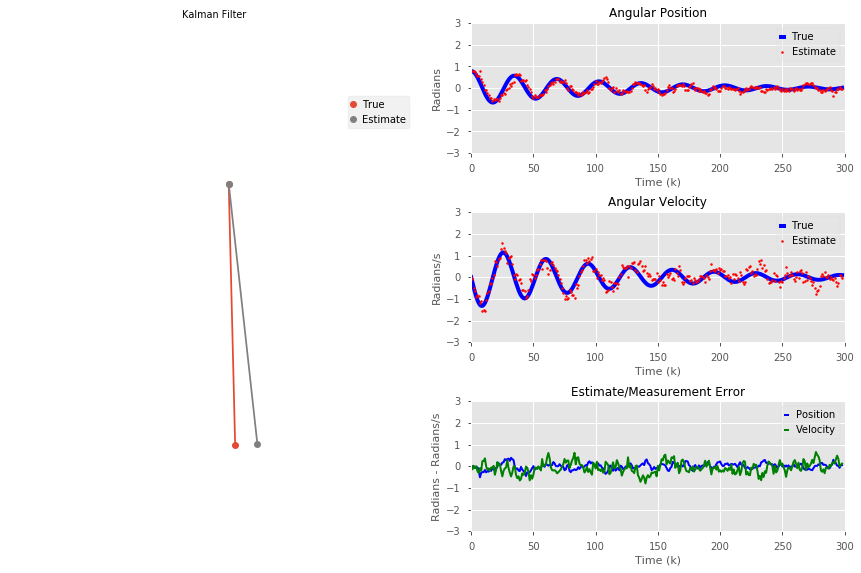

In [20]:
fig = plt.figure(figsize=(12, 8));
annpen = animated_pendulum(fig, tm, Tm, L, xm, xhat, 'Kalman Filter')
annpen_animation = annpen.get_animation_video(); annpen_animation

The linear Kalman Filter fairs better than the raw measurements, we are able to leverage the knowledge of the system dynamics, and the process and measurement stochastic properties to better estimate the states. But we have lost information by linearizing and discretizing the system, but there are better ways to estimate our states surely.

## Hybrid Extended Kalman Filter
Let's try a filter that is better suited for our system (continous nonlinear dynamics and discrete measurements).
To review, here is our dynamic system. 
$$\dot{x} =f\left(x,u,w,t\right)=\left\lbrack \begin{array}{c}
\theta^{˙} \\
\frac{-b}{\mathit{\text{mL}}}\theta^{˙} -\frac{g}{L}\sin \left(\theta \right)
\end{array}\right\rbrack +w$$

And the following is a summary of the Hybrid Extended Kalman Filter:
Given the dynamic system:
$$\dot{x} =f\left(x,u,w,t\right)$$
$$y_k =h_k \left(x_k ,v_k \right)$$
$$w\left(t\right)\sim N\left(0,Q\right)$$
$$v_k ]simN\left(0,R\right)$$

And initialized as follows:
$${\hat{x} }_0^+ =E\left(x_0 \right)$$
$$P_0^+ =E\left\lbrack \left(x_0 -{\hat{x} }_0^+ \right){\left(x_0 -{\hat{x} }_0^+ \right)}^T \right\rbrack$$

For each k:
a. At every Ts integrate the state estimate and its covariance using:
                    $$\dot{x} =f\left(\hat{x} ,u,0,t\right)$$
                    $$\dot{P} =\text{AP}+PA^T +\text{LQ}{\mathrm{L}}^T$$
                    where
                    $$L=\frac{\partial }{\partial w}f|_{\hat{x} }$$
                    $$A=\frac{\partial }{\partial x}f|_{\hat{x} }$$
b. At every Tm compute the gain, the aposteriori state estimate and the apostriori error covariance:
$$K_k =P_k^- H_k^T {\left(H_k P_k^- H_k^T +{M_k R}_k M_k^T \right)}^{-1}$$
$${\hat{x} }_k^+ ={\hat{x} }_k^- +K_k \left(y_k -h_k \left({\hat{x} }_k ,0\right)\right)$$
$$P_k^+ \text{ }=\left(I-{\mathrm{K}}_k H_k \right)P_k^- {\left(I-{\mathrm{K}}_k H_k \right)}^T +K_k {M_k R}_k M_k^T K_k^T$$
where
$$M=\frac{\partial }{\partial v}h|_{\hat{x} }$$

The process noise is not a function of x, and the measurement model is linear so , in this case. We do however need to compute A
$$A=\left\lbrack \begin{array}{c}
\frac{\partial }{\partial x_1 }f_1  & \frac{\partial }{\partial x_2 }f_1 \\
\frac{\partial }{\partial x_1 }f_2  & \frac{\partial }{\partial x_2 }f_2 
\end{array}\right\rbrack =\left\lbrack \begin{array}{c}
0 & 1\\
-\frac{g}{L}\cos \left(\theta \right) & \frac{-b}{\mathit{\text{mL}}}
\end{array}\right\rbrack$$

Let's implement this Hybrid EKF to estimate our states, using the same initializations used above in the linear case. Note that our measurements come at a lower frequency than our integration Ts, to account for this, we loop through 0:Ts:Tfinal and peform the time update at every iteration, but only perform the measurement update when we actually receive the measurement.
But we believe we have more confidence in our process, so let's change the process noise covariance matrix to reflect th


In [15]:
Qc = [[pow(0.05,2), 0],[0, pow(0.05,2)]]
print(Qc)

[[0.0025000000000000005, 0], [0, 0.0025000000000000005]]


In [16]:
# Setup 
P = zeros([n,n,points]);
K = zeros([n,m,points]);
r=zeros([m,points]);
P[:,:,0] = diag([pow(.1,2), pow(.1,2)]);
xhat_ekf = zeros([n,points]);
xdot_error = xhat_ekf;
xhat_ekf[:,0] = x0;
def fx(x):
    return array([x[1], -b/(m*L)*x[1]-g/L*sin(x[0])])
def A_taylor(x):
    return array([[0, 1],[-g/L*cos(x[0]), -b/(m*L)]]);

k = 1;
samples = len(tm);
Tm = Tfinal/(samples-1);
# We won't keep a history of states during time update, so just use temp variables.
xhat_ekf_apriori = xhat_ekf[:,0];
P_apriori = P[:,:,0];

for ks in arange(0, uint16(Tfinal/Ts)):
    
    #Integrate the state and covariance
    xhat_dot = fx(xhat_ekf_apriori);
    A = A_taylor(xhat_ekf_apriori);
    # Process vs Linearized
    xhat_ekf_apriori = xhat_ekf_apriori + Ts*xhat_dot;
    
    Pdot = dot(A,P_apriori) + dot(P_apriori, linalg.inv(A)) + Qc;
    P_apriori  = P_apriori  + Ts*Pdot;
    # Check if we have a measurement  

    if uint16(ks * 100) == uint16((k-1) * uint16(Tm/Ts) * 100) and k < points: # TODO: Not ideal fix
        # Measurement Update
        yhat = dot(H, xhat_ekf_apriori);
        
        # Optimal Gain
        K[:,:,k] = dot(P_apriori, H.transpose()) * linalg.inv( H*P_apriori*H.transpose() + R);
        
        # Measurements Update
        P[:,:,k] = (eye(n) - dot(K[:,:,k],H))*P_apriori;
        r[:,k] = y[:,k]-yhat;
        xhat_ekf[:,k] = xhat_ekf_apriori + dot(K[:,:,k],r[:,k]);
        
        # Feed aposteriori to time update loop
        xhat_ekf_apriori = xhat_ekf[:,k];
        P_apriori = P[:,:,k];
        
        # increment measurement update

        k=k+1;

ekf_estimate_error = (xm - xhat_ekf);
ekf_estimate_error_rms = rmse2(ekf_estimate_error);
print('The root-mean-square of the Hybrdi EKF estimate errors for position and velocity are:', ekf_estimate_error_rms)


The root-mean-square of the Hybrdi EKF estimate errors for position and velocity are: (0.044586135771056155, 0.088524545770288121)


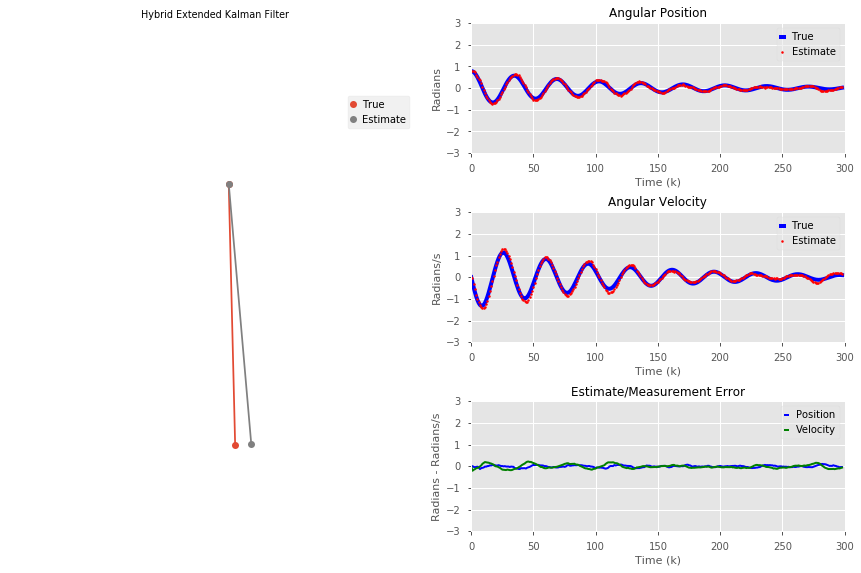

In [21]:
fig = plt.figure(figsize=(12, 8));
annpen = animated_pendulum(fig, tm, Tm, L, xm, xhat_ekf, 'Hybrid Extended Kalman Filter')
annpen_animation = annpen.get_animation_video(); annpen_animation